In [64]:
import time
print(f"Last updated on {time.asctime(time.gmtime())} UTC")

Last updated on Fri Dec 20 16:47:53 2019 UTC


### Purpose

The purpose of the Jyutping analysis in this notebook is twofold. One, to help facilitate the planning of HKIME.
Two, to serve as documentation. We hope that any reader will be able to understand the technical inner workings of HKIME from reading this notebook.

### Conventions
For consistency and clarity, we will establish the convention of using a character to mean an individual Jyutping syllable or Chinese character such as "粵" and "Jyut". To further disambiguate, we may refer to Jyutping character as a syllable. We will define a word as a sequence of more than one characters that represents a distinct or more specific semantical meaning than the individual characters themselves. For instance, we will consider "香港" as a word. One may think of character and word in Chinese as 字 and 詞 respectively.

## Jyutping Dictionary Initialization

In [3]:
from matplotlib import pyplot as plt
from jyutping_dict import JyutpingDict
import numpy as np

In [4]:
jd = JyutpingDict()

Dictionary of 701 Jyutpings mapping to 38643 different Chinese characters created


## Statistics

In [63]:
# TODO: Graph all this with matplotlib
# print("Prefix Frequencies")
# print(jd.prefix_freq)
# print("Suffix Frequencies")
# print(jd.suffix_freq)
# print("2-gram Frequencies")   # Plot with 2D heatmap
# print(jd.twoGram_freq)
num_suffixes = len(jd.twoGramTail_freq)
num_prefixes = len(jd.twoGramHead_freq)
print(f"Number of valid Jyutping 2-gram suffixes: {num_suffixes}")
print("Percentage of latin 2-grams that are", \
      f"valid 2-gram suffixes: {num_suffixes * 100/(26 * 26):.2f}%")
print(f"Number of valid Jyutping 2-gram prefixes: {num_prefixes}")
print("Percentage of latin 2-grams that are", \
      f"valid 2-gram prefixes: {num_prefixes * 100/(26 * 26):.2f}%")

Number of valid Jyutping 2-gram suffixes: 83
Percentage of latin 2-grams that are valid 2-gram suffixes: 12.28%
Number of valid Jyutping 2-gram prefixes: 113
Percentage of latin 2-grams that are valid 2-gram prefixes: 16.72%


Jyutping Length Statistics


<BarContainer object of 6 artists>

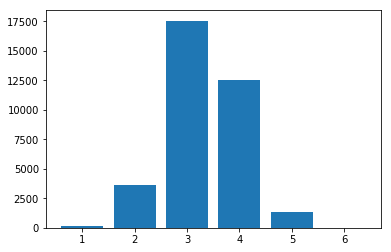

In [35]:
print("Jyutping Length Statistics")
jyutpingLength_dict = {}
for key in jd.jyutdict:
    if len(key) not in jyutpingLength_dict:
        jyutpingLength_dict[len(key)] = len(jd.jyutdict[key])
    else:
        jyutpingLength_dict[len(key)] += len(jd.jyutdict[key])
plt.bar(jyutpingLength_dict.keys(), jyutpingLength_dict.values())

In the following graph, it is very clear which letters are more likely to be prefixes and which are more likely to be suffixes. So, this could be a potentially simple way to dissect Jyutping strings.

Text(0.5, 1.0, 'Suffix Frequencies')

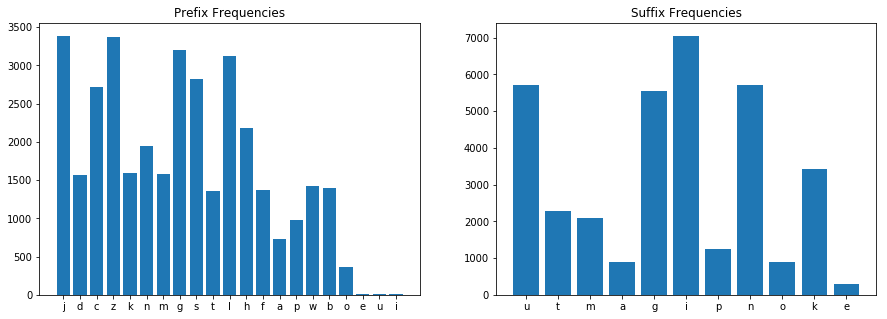

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].bar(jd.prefix_freq.keys(), jd.prefix_freq.values())
ax[0].set_title("Prefix Frequencies")
ax[1].bar(jd.suffix_freq.keys(), jd.suffix_freq.values())
ax[1].set_title("Suffix Frequencies")

## Splitting Jyutping Boundaries

An intelligent IME should be able to determine the boundaries of the individual Jyutpings for each character.
For example, we wish to split "Jyutping (粤拼)" into ["jyut (粤)", "ping (拼)"].

### Goals:
- Seperate Fuzzy Jyutping (模糊拼音 in regular pinyin IME's)
- Seperate Incomplete Jyutping ("dg" -> "點解")

### Problem Statement
For a given input Jyutping string corresponding to two words $S$, define the event $s_i$ as being $S[i]$ is the last character of the Jyutping corresponding to the first word and $S[i + 1]$ is the first character for the next word. Thus, the problem can be expressed as finding $\max_{i} \mathbb{P}(s_i)$.



### Head and Tail 2-gram Approach
In the following, we will define $g_k$ as the 2-gram $S[k: k + 2]$. We will also let $H(g_k)$ and $T(g_k)$ denote the events that $g_k$ is a head 2-gram and a tail 2-gram respectively. 

It is reasonable to assume that $H$ and $T$ are independent. We will also make the assumption that $$\max_{i} \mathbb{P}(s_i) = \max_i \mathbb{P}(g_{i - 1} \text{is a tail 2-gram} \cap g_{i + 1}
\text{is a head 2-gram}),$$
which we can simplify with our independence assumption to
$$\max_i \mathbb{P}(s_i) = \max_i \mathbb{P}(T(g_{i-1}) \cap H(g_{i+1})) = \max_i \mathbb{P}(T(g_{i-1}))\mathbb{P}(H(g_{i+1})).$$

In [7]:
def ht2gram_split(jyutdict, jyutping_input):
    # TODO: Edge cases for short inputs causing index OOB
    # and case that no valid split could be found
    
    def get_2gram(g_k):
        return jyutping_input[g_k : min(g_k + 2, len(jyutping_input))]
    
    def calculate_prob(s_i):
        head_p = jyutdict.calc_twoGramTail_prob(get_2gram(s_i - 1))
        tail_p = jyutdict.calc_twoGramHead_prob(get_2gram(s_i + 1))
        return head_p * tail_p
    
    idxs = len(jyutping_input) - 1
    probs = [calculate_prob(i) for i in range(idxs)]
    max_i = max(range(idxs), key=calculate_prob)
        
    return jyutping_input[:max_i + 1], jyutping_input[max_i + 1:]

In [8]:
# 粵拼、一點、丁丁、叉燒
jyutping_list = ["jyutping", "jatdim", "dingding", "caasiu"]
for j_input in jyutping_list:
    first, second = ht2gram_split(jd, j_input)
    print(first, second)

jyut ping
jat dim
ding ding
caa siu


In [14]:
# Accuracy testing with fuzzer input, may generate invalid words
jyutping_list = list(jd.jyutdict.keys())
num_jyutping = len(jyutping_list)
def generate_random_pair():
    a = np.random.randint(0, num_jyutping)
    b = np.random.randint(0, num_jyutping)
    return (jyutping_list[a] + jyutping_list[b],
            jyutping_list[a],
            jyutping_list[b])

def generate_fuzz(count):
    return [generate_random_pair() for i in range(count)]


In [10]:
fuzz = generate_fuzz(5000)

In [31]:
accuracy_count = 0
for j in fuzz:
    jyutping_input = j[0]
    first, second = ht2gram_split(jd, jyutping_input)
    if first == j[1] and second == j[2]:
        accuracy_count += 1
    # else:
    #     print(first, second, j[1], j[2])
# print("----------------------------------------")
print(f"Number of accurate segmentations: {accuracy_count}")
print("Number of tests: 5000")
print(f"Percentage correct: {accuracy_count * 100 / 5000}%")

Number of accurate segmentations: 4587
Number of tests: 5000
Percentage correct: 91.74%


###  Extensions to the Head and Tail 2-gram Approach

#### N-gram Approaches
Now, you may be wondering, what about n-gram's? From the statistics section, we see that the bulk of Jyutping characters / syllables are either 3 or 4 *latin* characters long. Therefore, segmentation via n-grams for $n > 2$ will not be very helpful. However, 1-grams are worth exploring, and will be in the next section.


#### Ranked Suggestions
It is ok to not achieve best 
Here, we modify our `ht2gram_split()` method slightly to instead return a list of candidate splits ranked in order of likelihood. Since we know the entire list of valid Jyutpings (in `JyutpingDict`), we can eliminate splits with $0$ probability. Similarly, we also know that the correct split will have a guaranteed non-zero probability.  This will help negate the inaccuracy of our probabilistic method.

In [25]:
def ht2gram_split_list(jyutdict, jyutping_input):
    # TODO: Edge cases for short inputs causing index OOB
    # and case that no valid split could be found
    
    def get_2gram(g_k):
        return jyutping_input[g_k : min(g_k + 2, len(jyutping_input))]
    
    def calculate_prob(s_i):
        head_p = jyutdict.calc_twoGramTail_prob(get_2gram(s_i - 1))
        tail_p = jyutdict.calc_twoGramHead_prob(get_2gram(s_i + 1))
        return head_p * tail_p
    
    idxs = list(range(len(jyutping_input) - 1))
    probs = [calculate_prob(i) for i in idxs]
    idxs.sort(key=calculate_prob)
    idxs = list(filter(lambda x: x > 0, idxs))
    
    def idx_to_split(idx):
        return (jyutping_input[:idx + 1], jyutping_input[idx + 1:])
        
    return [idx_to_split(idx) for idx in idxs]


In [32]:
accuracy_count = 0
for j in fuzz:
    jyutping_input = j[0]
    candidates = ht2gram_split_list(jd, jyutping_input)
    if (j[1], j[2]) in candidates:
        accuracy_count += 1
    # else:
    #     print(candidates, (j[1], j[2]))
print("----------------------------------------")
print(f"Number of accurate segmentations: {accuracy_count}")
print("Number of tests: 5000")
print(f"Percentage correct: {accuracy_count * 100 / 5000}%")

# TODO, as we can see if you uncomment the else statement,
# we really need to handle the short jyutping cases

----------------------------------------
Number of accurate segmentations: 4979
Number of tests: 5000
Percentage correct: 99.58%


### Adaptations of Head and Tail to 1-grams

We willl now experiment with using 1-grams. The reason behind exploring this approach is that most modern IMEs are intelligent enough to predict based on a "one-to-one" mapping of individual *latin* characters to individual *Chinese* characters. For instance, we wish to be able to predict "dg" -> "點解".

Seperating a string into individual characters is a trivial task. However, we also wish to be able to interpret a mixture of 1-grams corresponding to certain characters and n-grams corresponding to complete Jyutping syllables, which is slightly more involved. That is, being able to disambiguate "dig" -> "dim'g" -> "點解".